In [1]:
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score ,roc_auc_score ,roc_curve, auc , precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

plt.style.use('seaborn')
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_rows', 100)

# GradientBoostingClassifier

In [2]:
#reading the data
from scaled_data import *
df_X,df_y = clean_data()


In [5]:
#https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-2-feature-selection-and-ranking/

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from SpFtSel import SpFtSel
from sklearn.naive_bayes import BernoulliNB

X_SpF = df_X.copy()#.values

y_SpF = df_y#.values.ravel() # target


#Splitting data test&train 
X_train_SpF, X_test_SpF, y_train_SpF, y_test_SpF= train_test_split(X_SpF, y_SpF, test_size=0.25, random_state=123)


from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
#sm =ADASYN(n_neighbors=20)
sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train_SpF,y_train_SpF)


X =  X_train_bal    #Feature Matrix
y = y_train_bal.values.ravel()         #Target Variable

# make sure the results are repeatable
np.random.seed(8)


x =X.values#.ravel()


# specify a wrapper to use
#wrapper =  LogisticRegression(solver = 'newton-cg',max_iter = 2000  ,class_weight={0:0.2,1:0.8},random_state=123 )
wrapper =  DecisionTreeClassifier(max_depth=3,random_state=123 )
#wrapper = GradientBoostingClassifier(random_state=123,n_estimators=50,max_depth=5,min_samples_split=40)
#wrapper = BernoulliNB()
#wrapper = RandomForestClassifier()
#wrapper  =RandomForestClassifier(random_state=123,n_estimators=700,min_samples_split=60,class_weight={0:0.20,1:0.80})

# specify a metric to maximize
# (by default, sklearn metrics are defined as "higher is better")
# you need to make sure your scoring metric is consistent with your problem type,
# based on whether it is a binary or multi-class classification problem
# example: accuracy, f1, roc_auc, f1_weighted ,etc.
# more info on the scoring metrics can be found here:
# https://scikit-learn.org/stable/modules/model_evaluation.html
scoring = 'f1_weighted'

# set the engine parameters
sp_engine = SpFtSel(x, y, wrapper, scoring)

# run the engine
# available engine parameters:
# 1. num_features: how many features to select
#    (in addition to features to keep, if any)
#    default value is 0 and it results in automatic feature selection
# 2. run_mode: 'regular' (default) or 'extended'
# 3. stratified_cv: whether CV should be stratified or not (default is True)
#    stratified_cv must be set to False for regression problems
# 4. n_jobs: number of cores to be used in cross-validation (default is 1)
# 5. print_freq: print frequency for the output (default is 5)
# 6. features_to_keep_indices: indices of features to keep: default is None
sp_run = sp_engine.run(num_features=6 )#,stratified_cv = False)

# get the results of the run
sp_results = sp_run.results

# list of available keys in the engine output
print('Available keys:\n', sp_results.keys())

# performance value of the best feature set
print('Best value:', sp_results.get('best_value'))

# indices of selected features
print('Indices of selected features: ', sp_results.get('features'))

# importance of selected features
print('Importance of selected features: ', sp_results.get('importance').round(3))

# number of iterations for the optimal set
print('Total iterations for the optimal feature set:', sp_results.get('total_iter_for_opt'))
fs_indices_spsa = sp_results.get('features')

best_features_spsa = X.columns[fs_indices_spsa].values
best_features_spsa

spFtSel-INFO: Algorithm run mode: regular
spFtSel-INFO: Wrapper: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
spFtSel-INFO: Scoring metric: f1_weighted
spFtSel-INFO: Number of features: 63
spFtSel-INFO: Number of observations: 15660
spFtSel-INFO: iter: 0, value: 0.673, std: 0.009, num. features: 6, best value: 0.673
spFtSel-INFO: iter: 5, value: 0.677, std: 0.011, num. features: 6, best value: 0.677
spFtSel-INFO: iter: 10, value: 0.676, std: 0.009, num. features: 6, best value: 0.677
spFtSel-INFO: iter: 15, value: 0.677, std: 0.007, num. features: 6, best value: 0.677
spFtSel-INFO: iter: 20, value: 0.401, std: 0.00

Available keys:
 dict_keys(['_wrapper', '_scoring', 'selected_data', 'iter_results', 'features', 'importance', 'num_features', 'total_iter_overall', 'total_iter_for_opt', 'best_value', 'best_std'])
Best value: 0.89
Indices of selected features:  [21 25 59 19 41 54]
Importance of selected features:  [1. 1. 1. 1. 1. 1.]
Total iterations for the optimal feature set: 29


array(['Region_dummies_1', 'Region_dummies_5',
       'average_informational_duration_skew_s', 'Browser_dummies_12',
       'TrafficType_dummies_12', 'PageValues_skew_s'], dtype=object)

In [3]:
from sklearn.ensemble import GradientBoostingClassifier


gbm_model_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xgbm_model = gbm_model_Xdata[best_features_spsa].values
#Xgbm_model= gbm_model_Xdata[cols_2].values
Xgbm_model = gbm_model_Xdata.values

#getting the values of our y:
y_gbm_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xgbm_model, y_gbm_model , test_size=0.25, random_state=123)



gbm_model = GradientBoostingClassifier(random_state=123)

gbm_model.fit(X_train, y_train)

gbm_train_pred= gbm_model.predict(X_train)

gbm_test_pred = gbm_model.predict(X_test)


rkf ='''rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(gbm_model,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(gbm_model,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())'''


print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,gbm_test_pred))
print("Precision:",precision_score(y_test,gbm_test_pred))
print("Recall:",recall_score(y_test,gbm_test_pred))
roc_auc = roc_auc_score(y_test, gbm_test_pred)
print('AUC' ,roc_auc)

print('Test Classification Report')
print(classification_report(y_test,gbm_test_pred))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, gbm_test_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('Roc -Auc Curve',roc_auc)




Test Metrics
Accuracy: 0.88582549464807
Precision: 0.6674698795180722
Recall: 0.5641547861507128
AUC 0.755457022704986
Test Classification Report
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2592
           1       0.67      0.56      0.61       491

    accuracy                           0.89      3083
   macro avg       0.79      0.76      0.77      3083
weighted avg       0.88      0.89      0.88      3083

Roc -Auc Curve 0.755457022704986


In [4]:
from sklearn.ensemble import GradientBoostingClassifier


gbm_model_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xgbm_model = gbm_model_Xdata[best_features_spsa].values
#Xgbm_model= gbm_model_Xdata[cols_2].values
Xgbm_model = gbm_model_Xdata.values

#getting the values of our y:
y_gbm_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xgbm_model, y_gbm_model , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)


gbm_model = GradientBoostingClassifier(random_state=123,n_estimators=50,max_depth=5,min_samples_split=40)

gbm_model.fit(X_train_bal, y_train_bal)

gbm_train_pred= gbm_model.predict(X_train_bal)

gbm_test_pred = gbm_model.predict(X_test)


rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(gbm_model,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(gbm_model,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())


print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,gbm_test_pred))
print("Precision:",precision_score(y_test,gbm_test_pred))
print("Recall:",recall_score(y_test,gbm_test_pred))
roc_auc = roc_auc_score(y_test, gbm_test_pred)
print('AUC' ,roc_auc)

print('Test Classification Report')
print(classification_report(y_test,gbm_test_pred))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, gbm_test_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('Roc -Auc Curve',roc_auc)




model bias (f1-score): 0.9240982903686914
model variance (f1-score): 0.007151790676263708
model bias (ROC/AUC): 0.978238840644953
model variance (ROC/AUC): 0.0024710730957034264
Test Metrics
Accuracy: 0.8696075251378528
Precision: 0.5718901453957996
Recall: 0.7209775967413442
AUC 0.8093699712101784
Test Classification Report
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      2592
           1       0.57      0.72      0.64       491

    accuracy                           0.87      3083
   macro avg       0.76      0.81      0.78      3083
weighted avg       0.89      0.87      0.88      3083

Roc -Auc Curve 0.8093699712101784


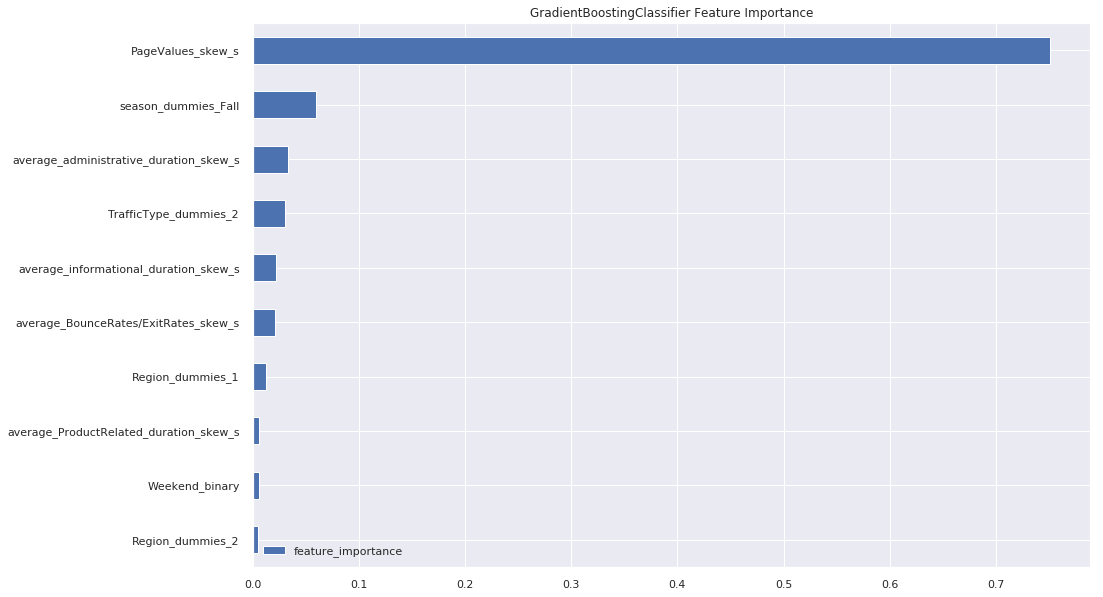

In [6]:
#https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(gbm_model_Xdata.columns, gbm_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
sns.set()
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature_importance'})
importances.sort_values(by='feature_importance').tail(10).plot(kind='barh', rot=0 , figsize=(15,10) ,title ='GradientBoostingClassifier Feature Importance')

In [7]:
importances.sort_values(by='feature_importance').tail(5).index


Index(['average_informational_duration_skew_s', 'TrafficType_dummies_2', 'average_administrative_duration_skew_s', 'season_dummies_Fall', 'PageValues_skew_s'], dtype='object')

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

gbm_model_Xdata = df_X.copy() #making our X columns

best_features = ['average_BounceRates/ExitRates_skew_s', 'TrafficType_dummies_2', 'average_administrative_duration_skew_s', 'season_dummies_Fall', 'PageValues_skew_s']
#getting the values of our x features:
Xgbm_model = gbm_model_Xdata[best_features].values
#Xgbm_model= gbm_model_Xdata[cols_2].values
#Xgbm_model = gbm_model_Xdata.values

#getting the values of our y:
y_gbm_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xgbm_model, y_gbm_model , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)

#gbm_model =XGBClassifier()
gbm_model = GradientBoostingClassifier(random_state=123,n_estimators=50,max_depth=3,min_samples_split=40)

gbm_model.fit(X_train_bal, y_train_bal)

gbm_train_pred= gbm_model.predict(X_train_bal)

gbm_test_pred = gbm_model.predict(X_test)


rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(gbm_model,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(gbm_model,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())


print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,gbm_test_pred))
print("Precision:",precision_score(y_test,gbm_test_pred))
print("Recall:",recall_score(y_test,gbm_test_pred))
roc_auc = roc_auc_score(y_test, gbm_test_pred)
print('AUC' ,roc_auc)

print('Test Classification Report')
print(classification_report(y_test,gbm_test_pred))






model bias (f1-score): 0.8585172476115429
model variance (f1-score): 0.008572751256757346
model bias (ROC/AUC): 0.9325133581709488
model variance (ROC/AUC): 0.005908050870284726
Test Metrics
Accuracy: 0.8459292896529355
Precision: 0.510230179028133
Recall: 0.8126272912423625
AUC 0.8324324727816752
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      2592
           1       0.51      0.81      0.63       491

    accuracy                           0.85      3083
   macro avg       0.74      0.83      0.76      3083
weighted avg       0.89      0.85      0.86      3083



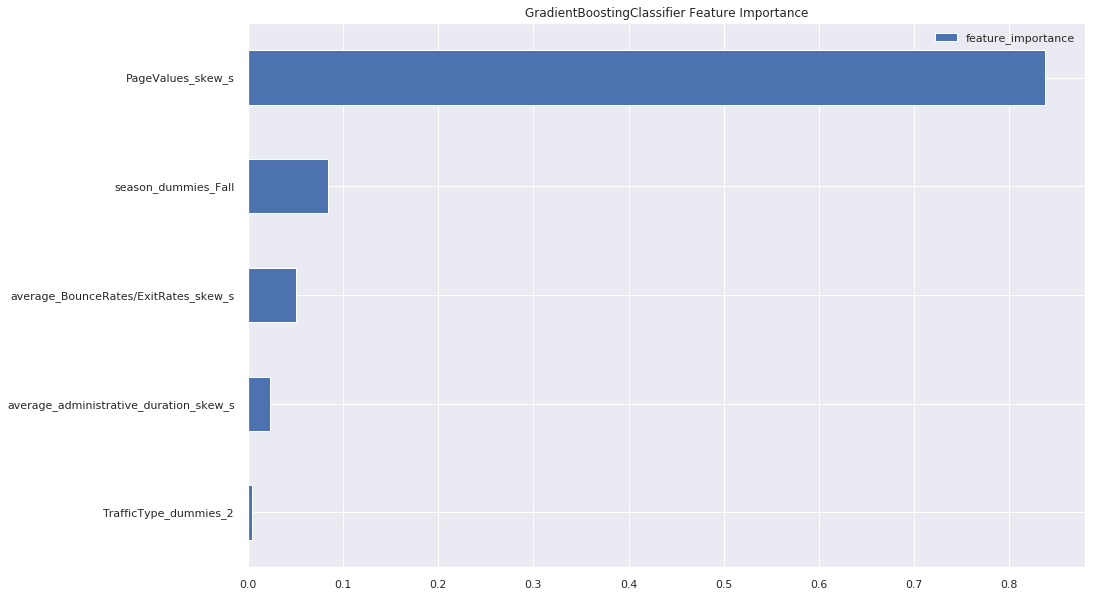

In [68]:
#https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(best_features, gbm_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
sns.set()
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature_importance'})
importances.sort_values(by='feature_importance').tail(10).plot(kind='barh', rot=0 , figsize=(15,10) ,title ='GradientBoostingClassifier Feature Importance')

In [43]:
gbm_model.estimators_[-1]

array([DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=40,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=RandomState(MT19937) at 0x7FD0A1CC8048,
                      splitter='best')], dtype=object)

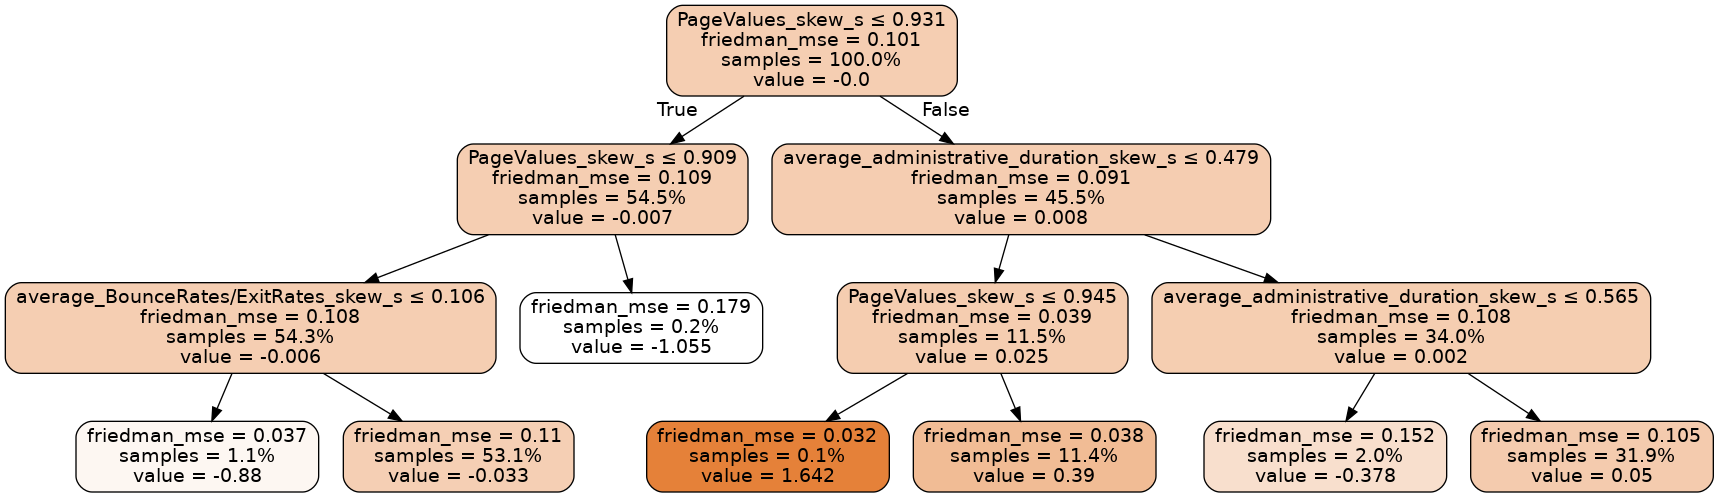

In [98]:
import graphviz

from sklearn import tree
import pydotplus

from sklearn.tree import export_graphviz 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
# Get the last tree 
tree_last = gbm_model.estimators_[-1,0]

dot_data = tree.export_graphviz(
    tree_last,
    out_file=None, filled=True,
    rounded=True,  
    special_characters=True,
    proportion=True, feature_names=best_features,
)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

#graph = graphviz.Source(dot_data)  
#graph 


Accuracy of the GBM on test set: 0.868
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2592
           1       0.56      0.76      0.65       491

    accuracy                           0.87      3083
   macro avg       0.76      0.82      0.78      3083
weighted avg       0.89      0.87      0.88      3083

Test Metrics
Accuracy: 0.8683100875770353
Precision: 0.5644916540212443
Recall: 0.7576374745417516
AUC 0.8234560829498881


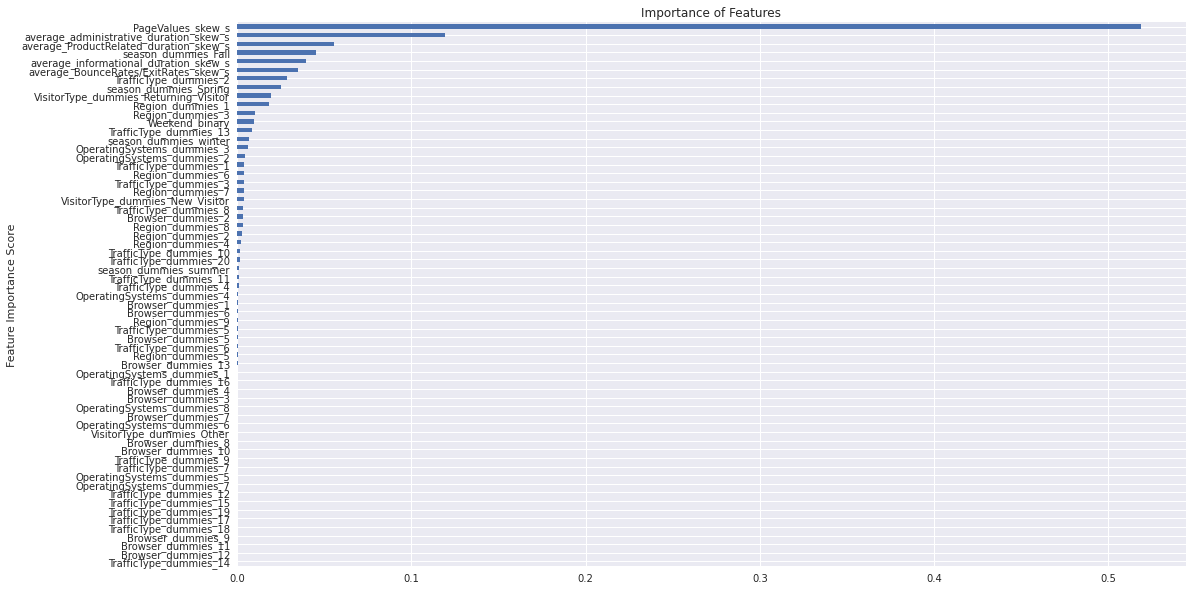

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedKFold

gbm_model_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xgbm_model = gbm_model_Xdata[best_features_spsa].values
#Xgbm_model= gbm_model_Xdata[cols_2].values
Xgbm_model = gbm_model_Xdata.values

#getting the values of our y:
y_gbm_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xgbm_model, y_gbm_model , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)



baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train_bal,y_train_bal)

feat_imp = pd.Series(baseline.feature_importances_, gbm_model_Xdata.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh', title='Importance of Features' , figsize = (17,10))
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test, y_test)))
pred=baseline.predict(X_test)
print(classification_report(y_test, pred))

print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,pred))
print("Precision:",precision_score(y_test,pred))
print("Recall:",recall_score(y_test,pred))
roc_auc = roc_auc_score(y_test, pred)
print('AUC' ,roc_auc)




# Tunign n_estimators and Learning rate

In [6]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),"f1" : "f1_weighted"}
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=123), 
            param_grid = p_test3, scoring=scoring,n_jobs=4,iid=False, cv=5,refit='AUC')
tuning.fit(X_train_bal,y_train_bal)
tuning.best_params_, tuning.best_score_

KeyboardInterrupt: 

In [29]:
#print('Best params for {}'.format(refit_score))
y_pred = tuning.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test,  y_pred)
print('AUC' ,roc_auc)

from sklearn.metrics import f1_score
print(f1_score(y_test,  y_pred, average='weighted'))
tuning.best_params_, tuning.best_score_



              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2592
           1       0.62      0.61      0.62       491

    accuracy                           0.88      3083
   macro avg       0.78      0.77      0.77      3083
weighted avg       0.88      0.88      0.88      3083

AUC 0.7716021881521711


0.8792103999772327

# Tunign max_depth

In [30]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),"f1" : "f1_weighted"}
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05,n_estimators=1250, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=123), 
            param_grid = p_test2, scoring=scoring,n_jobs=4,iid=False, cv=5 ,refit='AUC')
tuning.fit(X_train_bal,y_train_bal)
y_pred = tuning.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test,  y_pred)
print('AUC' ,roc_auc)

from sklearn.metrics import f1_score
print("f1",f1_score(y_test,  y_pred, average='weighted'))
tuning.best_params_, tuning.best_score_

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[[2433  159]
 [ 214  277]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2592
           1       0.64      0.56      0.60       491

    accuracy                           0.88      3083
   macro avg       0.78      0.75      0.76      3083
weighted avg       0.87      0.88      0.88      3083

AUC 0.7514060967790601
0.8760598921575777


({'max_depth': 7}, 0.9887790353439712)

Accuracy of the GBM on test set: 0.875
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2592
           1       0.62      0.57      0.59       491

    accuracy                           0.88      3083
   macro avg       0.77      0.75      0.76      3083
weighted avg       0.87      0.88      0.87      3083



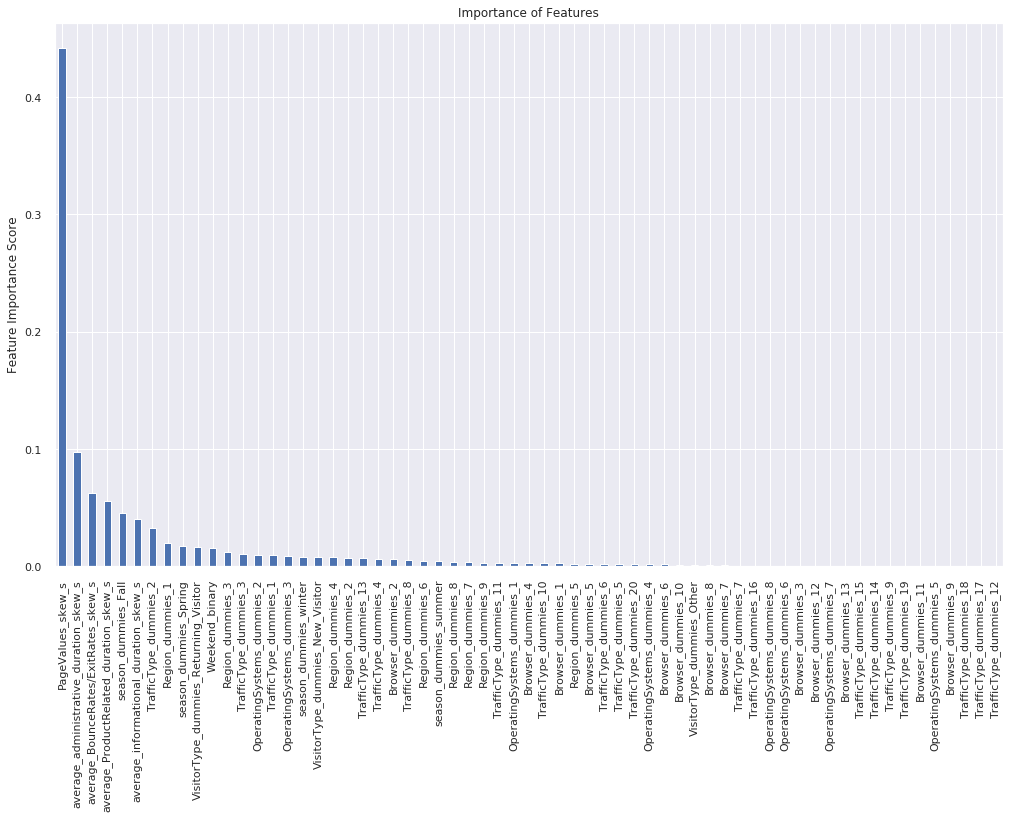

In [32]:
model1 = GradientBoostingClassifier(learning_rate=0.05,n_estimators=1250,max_depth=7, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=123)
model1.fit(X_train_bal,y_train_bal)
#predictors=list(X_train)
feat_imp = pd.Series(model1.feature_importances_, gbm_model_Xdata.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features' , figsize = (17,10))
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model1.score(X_test, y_test)))
pred=model1.predict(X_test)
print(classification_report(y_test, pred))

In [33]:
rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(model1,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(model1,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())




model bias (f1-score): 0.9425198489996525
model variance (f1-score): 0.0051475017673747485
model bias (ROC/AUC): 0.987390530606088
model variance (ROC/AUC): 0.001650890503365215


# Min sample split and min samples leaf


In [34]:
p_test4 = {'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9]}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),"f1" : make_scorer(f1_score)}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05,n_estimators=1250,max_depth=7, subsample=1,max_features='sqrt', random_state=123), 
            param_grid = p_test4, scoring=scoring,n_jobs=4,iid=False, cv=5 ,refit='f1')
tuning.fit(X_train_bal,y_train_bal)

y_pred = tuning.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test,  y_pred)
print('AUC' ,roc_auc)

from sklearn.metrics import f1_score
print("f1",f1_score(y_test,  y_pred, average='weighted'))
tuning.best_params_, tuning.best_score_

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[[2423  169]
 [ 212  279]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2592
           1       0.62      0.57      0.59       491

    accuracy                           0.88      3083
   macro avg       0.77      0.75      0.76      3083
weighted avg       0.87      0.88      0.87      3083

AUC 0.7515137443111816
f1 0.8740977973263414


({'min_samples_leaf': 1, 'min_samples_split': 10}, 0.9143986425515129)

In [41]:
results = pd.DataFrame(tuning.cv_results_)
results.iloc[4]

mean_fit_time                          14.5711
std_fit_time                          0.197575
mean_score_time                        0.24748
std_score_time                       0.0101368
param_min_samples_leaf                       1
param_min_samples_split                     10
params                     {'min_samples_le...
split0_test_AUC                       0.951288
split1_test_AUC                       0.998453
split2_test_AUC                        0.99701
split3_test_AUC                       0.997944
split4_test_AUC                       0.998183
mean_test_AUC                         0.988576
std_test_AUC                         0.0186503
rank_test_AUC                                7
split0_test_Accuracy                  0.767241
split1_test_Accuracy                  0.969987
split2_test_Accuracy                  0.966156
split3_test_Accuracy                  0.964879
split4_test_Accuracy                  0.963282
mean_test_Accuracy                    0.926309
std_test_Accu

No handles with labels found to put in legend.


0.9061517814487943


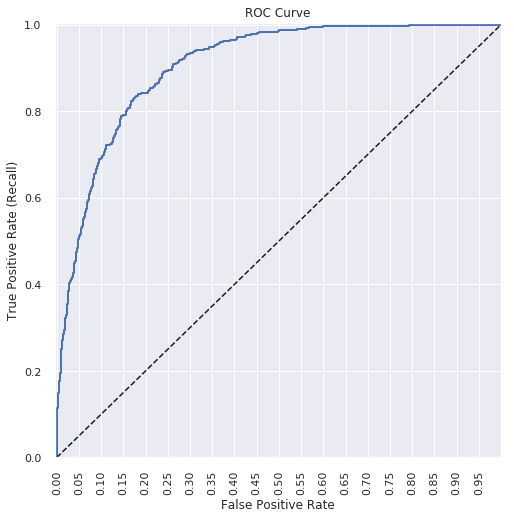

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')



y_scores = tuning.predict_proba(X_test)[:, 1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc) # AUC of ROC
plot_roc_curve(false_positive_rate, true_positive_rate)
results = pd.DataFrame(tuning.cv_results_)
results

# Tuning Max Features

In [44]:
#TUNING MAX FEATURES
p_test5 = {'max_features':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),"f1" : make_scorer(f1_score)}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05,n_estimators=1250,max_depth=7, min_samples_split=10, min_samples_leaf=1, subsample=1, random_state=123), 
param_grid = p_test5, scoring=scoring,n_jobs=4,iid=False, cv=5,refit='f1')
tuning.fit(X_train_bal,y_train_bal)
print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test,  y_pred)
print('AUC' ,roc_auc)

from sklearn.metrics import f1_score
print("f1",f1_score(y_test,  y_pred, average='weighted'))
tuning.best_params_, tuning.best_score_

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[[2423  169]
 [ 212  279]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2592
           1       0.62      0.57      0.59       491

    accuracy                           0.88      3083
   macro avg       0.77      0.75      0.76      3083
weighted avg       0.87      0.88      0.87      3083

AUC 0.7515137443111816
f1 0.8740977973263414


({'max_features': 15}, 0.9159611096975331)

No handles with labels found to put in legend.


0.906755236227402


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,...,std_test_Accuracy,rank_test_Accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,8.037820,0.116726,0.222261,0.004842,2,{'max_features': 2},0.943255,0.998539,0.996944,0.997871,...,0.092820,19,0.647208,0.968963,0.962848,0.969508,0.965453,0.902796,0.127817,19
1,9.477179,0.114893,0.234555,0.006716,3,{'max_features': 3},0.944356,0.998569,0.997259,0.998046,...,0.093571,18,0.645763,0.971091,0.966243,0.968323,0.966049,0.903494,0.128878,18
2,10.823899,0.184091,0.241141,0.008099,4,{'max_features': 4},0.947537,0.998630,0.997182,0.998032,...,0.090177,17,0.659941,0.970186,0.968082,0.968062,0.966049,0.906464,0.123268,17
3,12.135670,0.176993,0.245279,0.008466,5,{'max_features': 5},0.950451,0.998474,0.997125,0.998152,...,0.085489,16,0.679620,0.968682,0.965688,0.969264,0.965453,0.909741,0.115071,16
4,13.287212,0.164913,0.247562,0.008948,6,{'max_features': 6},0.950819,0.998495,0.996926,0.998074,...,0.083223,15,0.688039,0.970469,0.965070,0.968362,0.962804,0.910949,0.111486,15
5,14.583394,0.260183,0.247834,0.009681,7,{'max_features': 7},0.951288,0.998453,0.997010,0.997944,...,0.079565,1,0.703538,0.970789,0.967203,0.965902,0.964561,0.914399,0.105451,8
6,15.701220,0.212179,0.249146,0.008823,8,{'max_features': 8},0.951336,0.998366,0.996644,0.997869,...,0.079405,9,0.703734,0.969584,0.966605,0.966522,0.963077,0.913904,0.105105,11
7,16.922590,0.311670,0.247581,0.009115,9,{'max_features': 9},0.951513,0.998228,0.996648,0.997671,...,0.078957,8,0.705310,0.970186,0.964793,0.965645,0.964561,0.914099,0.104414,9
8,18.036627,0.198370,0.247563,0.008994,10,{'max_features':...,0.949980,0.998123,0.996553,0.997459,...,0.077952,12,0.707879,0.969603,0.964175,0.964706,0.961870,0.913647,0.102915,13
9,19.269276,0.296902,0.246481,0.009953,11,{'max_features':...,0.950632,0.997931,0.996264,0.997240,...,0.078109,13,0.707829,0.969584,0.963009,0.965347,0.962758,0.913705,0.102967,12


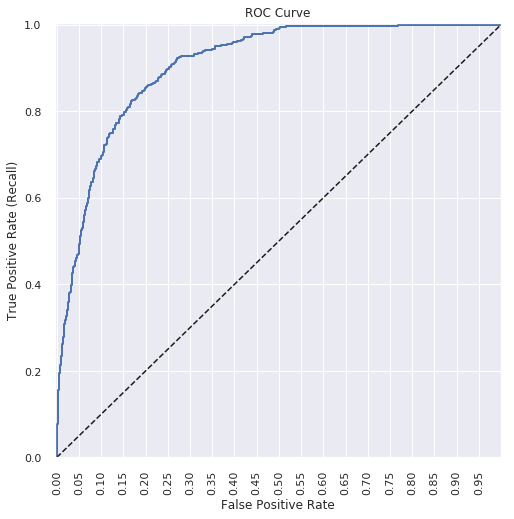

In [45]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')



y_scores = tuning.predict_proba(X_test)[:, 1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc) # AUC of ROC
plot_roc_curve(false_positive_rate, true_positive_rate)
results = pd.DataFrame(tuning.cv_results_)
results

# Subsample

In [46]:
p_test6= {'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),"f1" : make_scorer(f1_score)}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.05,n_estimators=1250,max_depth=7, min_samples_split=10, min_samples_leaf=1,max_features=15 , random_state=123), 
param_grid = p_test6, scoring=scoring,n_jobs=4,iid=False, cv=5 ,refit='f1')
tuning.fit(X_train,y_train)
y_pred = tuning.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test,  y_pred)
print('AUC' ,roc_auc)

from sklearn.metrics import f1_score
print("f1",f1_score(y_test,  y_pred, average='weighted'))
tuning.best_params_, tuning.best_score_

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[[2457  135]
 [ 226  265]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      2592
           1       0.66      0.54      0.59       491

    accuracy                           0.88      3083
   macro avg       0.79      0.74      0.76      3083
weighted avg       0.88      0.88      0.88      3083

AUC 0.7438157671418874
f1 0.8779367285958443


({'subsample': 0.8}, 0.6331998031278695)

No handles with labels found to put in legend.


0.9072031128208997


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,...,std_test_Accuracy,rank_test_Accuracy,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,10.094288,0.110981,0.173226,0.040238,0.7,{'subsample': 0.7},0.928563,0.927320,0.919141,0.911072,...,0.004499,2,0.640777,0.653696,0.620424,0.606654,0.643939,0.633098,0.017092,2
1,10.490380,0.115606,0.171255,0.040052,0.75,{'subsample': 0.75},0.929492,0.926614,0.918978,0.908251,...,0.007256,6,0.648649,0.662768,0.615087,0.592593,0.621723,0.628164,0.024879,5
2,10.871097,0.093482,0.170385,0.040378,0.8,{'subsample': 0.8},0.926785,0.925820,0.918342,0.909285,...,0.006554,1,0.648330,0.658824,0.627151,0.595331,0.636364,0.633200,0.021754,1
3,11.292773,0.077763,0.157575,0.009697,0.85,{'subsample': 0.85},0.927810,0.928880,0.917904,0.911085,...,0.005455,3,0.632381,0.661448,0.612403,0.610895,0.628788,0.629183,0.018262,4
4,11.607993,0.139745,0.167583,0.040500,0.9,{'subsample': 0.9},0.928692,0.929951,0.916902,0.911243,...,0.006260,4,0.642586,0.666667,0.609709,0.593625,0.626186,0.627754,0.025405,6
5,11.968701,0.104177,0.144997,0.001415,0.95,{'subsample': 0.95},0.929870,0.928563,0.917821,0.906139,...,0.006712,5,0.641075,0.667954,0.624521,0.589391,0.623574,0.629303,0.025617,3
6,12.088574,0.146074,0.141737,0.001380,1,{'subsample': 1},0.927219,0.928190,0.916747,0.907832,...,0.004702,7,0.626692,0.653772,0.606178,0.611219,0.625483,0.624669,0.016581,7


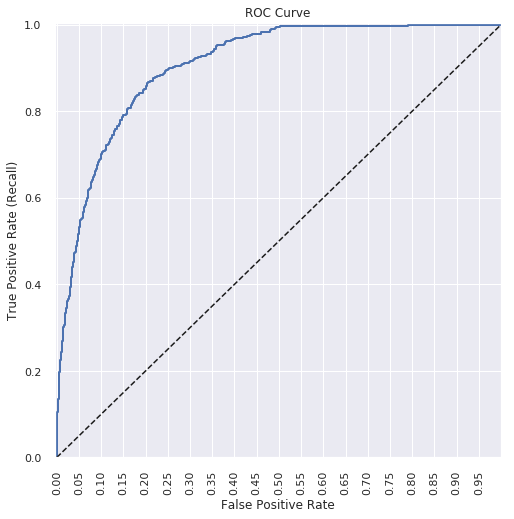

In [47]:
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')



y_scores = tuning.predict_proba(X_test)[:, 1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc) # AUC of ROC
plot_roc_curve(false_positive_rate, true_positive_rate)
results = pd.DataFrame(tuning.cv_results_)
results

# Evaluation of final model on Test set

Test Metrics
Accuracy: 0.8741485566007136
Precision: 0.6079664570230608
Recall: 0.5906313645621182
AUC 0.7592431514168616
f1 0.8734079544382773
Test Classification Report
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      2592
           1       0.61      0.59      0.60       491

    accuracy                           0.87      3083
   macro avg       0.77      0.76      0.76      3083
weighted avg       0.87      0.87      0.87      3083

model bias (f1-score): 0.9404939336227683
model variance (f1-score): 0.006192422039197822
model bias (ROC/AUC): 0.9867857142391567
model variance (ROC/AUC): 0.001933360847449641


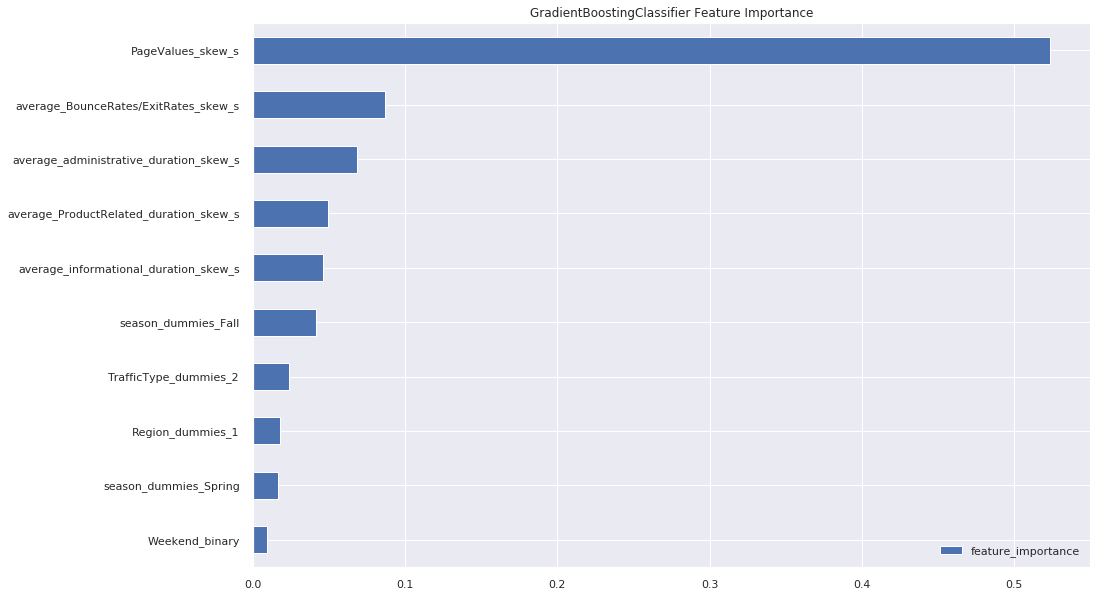

In [48]:
from sklearn.ensemble import GradientBoostingClassifier


gbm_model_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xgbm_model = gbm_model_Xdata[best_features_spsa].values
#Xgbm_model= gbm_model_Xdata[cols_2].values
Xgbm_model = gbm_model_Xdata.values

#getting the values of our y:
y_gbm_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xgbm_model, y_gbm_model , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)


gbm_model = GradientBoostingClassifier(learning_rate=0.05,n_estimators=1250,max_depth=7, min_samples_split=10,
                                       min_samples_leaf=1,max_features=15, subsample=0.8 , random_state=123,
                                      )

gbm_model.fit(X_train_bal, y_train_bal)

gbm_train_pred= gbm_model.predict(X_train_bal)

gbm_test_pred = gbm_model.predict(X_test)





print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,gbm_test_pred))
print("Precision:",precision_score(y_test,gbm_test_pred))
print("Recall:",recall_score(y_test,gbm_test_pred))
roc_auc = roc_auc_score(y_test, gbm_test_pred)
print('AUC' ,roc_auc)
print("f1",f1_score(y_test,  gbm_test_pred, average='weighted'))


print('Test Classification Report')
print(classification_report(y_test,gbm_test_pred))

rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(gbm_model,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(gbm_model,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())
#https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(gbm_model_Xdata.columns, gbm_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
sns.set()
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature_importance'})
importances.sort_values(by='feature_importance').plot(kind='barh', rot=0 , figsize=(15,10) ,title ='GradientBoostingClassifier Feature Importance')

No handles with labels found to put in legend.


0.9065407269115688
[[2405  187]
 [ 201  290]]


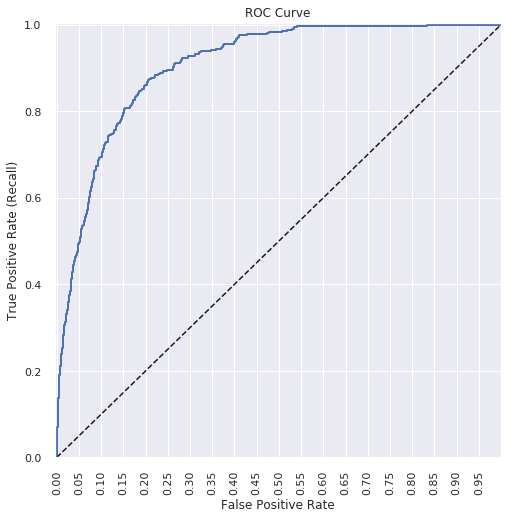

In [49]:
y_scores = gbm_model.predict_proba(X_test)[:, 1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc) # AUC of ROC
plot_roc_curve(false_positive_rate, true_positive_rate)
print(confusion_matrix(y_test, gbm_test_pred))



In [59]:
importances.sort_values(by='feature_importance').tail(15).index


Index(['Browser_dummies_2', 'TrafficType_dummies_8', 'Region_dummies_2', 'season_dummies_Spring', 'OperatingSystems_dummies_2', 'Region_dummies_3', 'Weekend_binary', 'Region_dummies_1',
       'TrafficType_dummies_2', 'average_informational_duration_skew_s', 'average_ProductRelated_duration_skew_s', 'average_administrative_duration_skew_s', 'average_BounceRates/ExitRates_skew_s',
       'season_dummies_Fall', 'PageValues_skew_s'],
      dtype='object')

Test Metrics
Accuracy: 0.8592280246513136
Precision: 0.5443234836702955
Recall: 0.7128309572301426
AUC 0.7998954168866762
f1 0.86653635121196
Test Classification Report
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      2592
           1       0.54      0.71      0.62       491

    accuracy                           0.86      3083
   macro avg       0.74      0.80      0.77      3083
weighted avg       0.88      0.86      0.87      3083



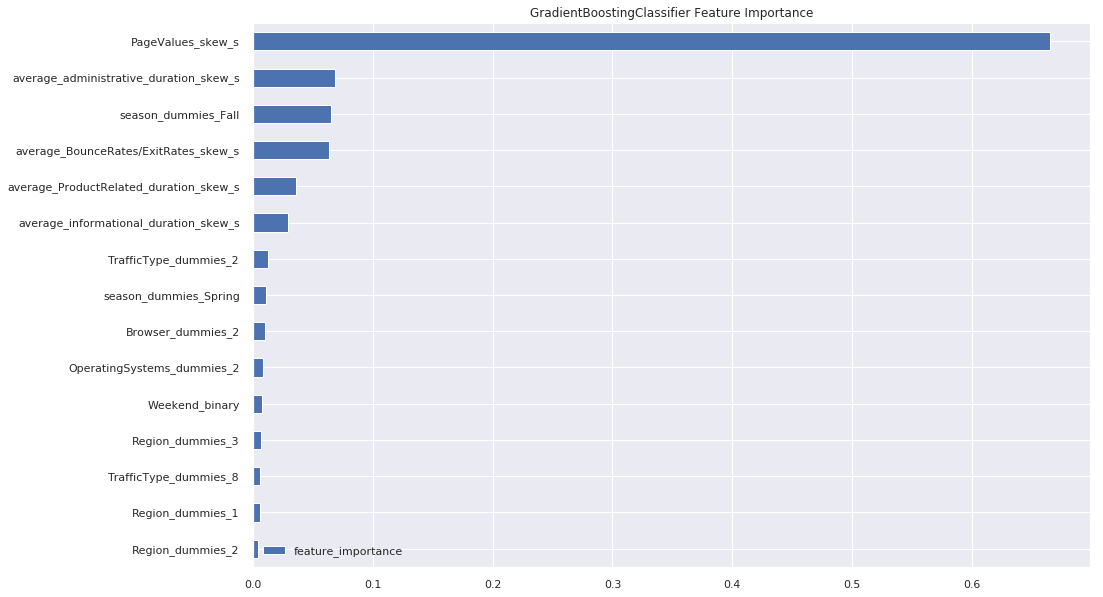

No handles with labels found to put in legend.


0.9050179464936763


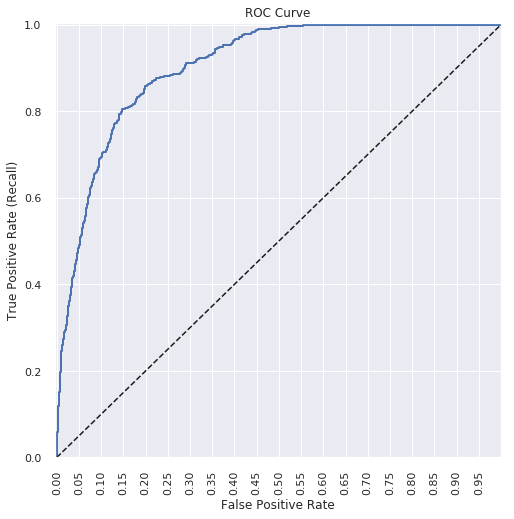

[[2299  293]
 [ 141  350]]


In [64]:
from sklearn.ensemble import GradientBoostingClassifier


gbm_model_Xdata = df_X.copy() #making our X columns
best_features_spsa = ['Browser_dummies_2', 'TrafficType_dummies_8', 'Region_dummies_2', 'season_dummies_Spring', 'OperatingSystems_dummies_2', 'Region_dummies_3', 'Weekend_binary', 'Region_dummies_1',
       'TrafficType_dummies_2', 'average_informational_duration_skew_s', 'average_ProductRelated_duration_skew_s', 'average_administrative_duration_skew_s', 'average_BounceRates/ExitRates_skew_s',
       'season_dummies_Fall', 'PageValues_skew_s']

#getting the values of our x features:
Xgbm_model = gbm_model_Xdata[best_features_spsa].values
#Xgbm_model= gbm_model_Xdata[cols_2].values
#Xgbm_model = gbm_model_Xdata.values

#getting the values of our y:
y_gbm_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xgbm_model, y_gbm_model , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE()
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)


gbm_model = GradientBoostingClassifier(learning_rate=0.05,n_estimators=1250,max_depth=4, min_samples_split=10,
                                       min_samples_leaf=1, subsample=0.8 , random_state=123,
                                      )

gbm_model.fit(X_train_bal, y_train_bal)

gbm_train_pred= gbm_model.predict(X_train_bal)

gbm_test_pred = gbm_model.predict(X_test)





print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,gbm_test_pred))
print("Precision:",precision_score(y_test,gbm_test_pred))
print("Recall:",recall_score(y_test,gbm_test_pred))
roc_auc = roc_auc_score(y_test, gbm_test_pred)
print('AUC' ,roc_auc)
print("f1",f1_score(y_test,  gbm_test_pred, average='weighted'))


print('Test Classification Report')
print(classification_report(y_test,gbm_test_pred))


#https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(best_features_spsa, gbm_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
sns.set()
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature_importance'})
importances.sort_values(by='feature_importance').plot(kind='barh', rot=0 , figsize=(15,10) ,title ='GradientBoostingClassifier Feature Importance')
plt.show()

y_scores = gbm_model.predict_proba(X_test)[:, 1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc) # AUC of ROC
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()
print(confusion_matrix(y_test, gbm_test_pred))




In [65]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(gbm_model,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(gbm_model,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())

model bias (f1-score): 0.9172821598577942
model variance (f1-score): 0.0037930202053999052
model bias (ROC/AUC): 0.9697689743242666
model variance (ROC/AUC): 0.0025061960727886007
